In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


   ### 1. 1 | Loading Data 

In [2]:
val_data = pd.read_csv('/kaggle/input/emotion-dataset/validation.csv')
train_data = pd.read_csv('/kaggle/input/emotion-dataset/training.csv')
test_data = pd.read_csv('/kaggle/input/emotion-dataset/test.csv')

In [3]:
print("Validation data :",val_data.shape)
print("Train data :",train_data.shape)
print("Test data :",test_data.shape)

Validation data : (2000, 2)
Train data : (16000, 2)
Test data : (2000, 2)


* There is a lot of data in test, in my case i divided it and put the est in the val_data 

In [4]:
half_test_data = test_data.iloc[1000:]
test_data = test_data.iloc[:1000]

val_data = pd.concat([val_data, half_test_data], axis=0)

print("new Vald data :",val_data.shape)
print("new Test data :",test_data.shape)

new Vald data : (3000, 2)
new Test data : (1000, 2)


In [5]:
train_data.head(10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


### 1. 2 | Adding Label Data

In [6]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_data['label_name'] = train_data['label'].map(labels_dict)
train_data.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [7]:
train_data.groupby(["label_name","label"]).size()

label_name  label
anger       3        2159
fear        4        1937
joy         1        5362
love        2        1304
sadness     0        4666
surprise    5         572
dtype: int64

### 1. 3 | Data Visualization

<Axes: xlabel='label_name'>

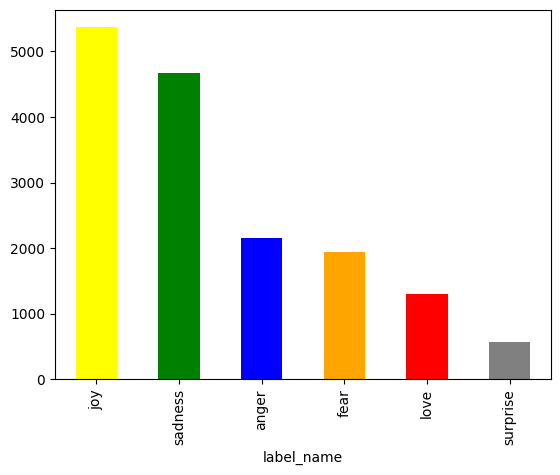

In [10]:
train_data["label_name"].value_counts().plot(kind='bar',color=['yellow', 'green', 'blue', 'orange', 'red','gray'])

# 2 | Data Cleaning

In [11]:
print(train_data.isnull().sum())
print(val_data.isnull().sum())
print(test_data.isnull().sum())

text          0
label         0
label_name    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


# 3 | Tokenisation & Stemming

In [12]:
all_list = train_data['text'].tolist() + test_data['text'].tolist() + val_data['text'].tolist()

In [13]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(all_list)
word_index1 = tokenizer1.word_index

print("Nombre of words without Stemming:",len(word_index1))

stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in word_index1.keys()]

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(stemmed_words)
word_index2 = tokenizer2.word_index

print("Nombre of words with Stemming:",len(word_index2))

Nombre of words without Stemming: 17096
Nombre of words with Stemming: 11705


* load all data to list : <b>[ [ Tokenised_Data ] , label ] </b>

In [16]:
def preprocess_data(data):
    new_data = []
    for index, row in data.iterrows():
        test_split = row['text'].split()
        stemmed_words2 = [stemmer.stem(word) for word in test_split]
        token_list= tokenizer2.texts_to_sequences([stemmed_words2])[0]
        new_data.append([token_list,row['label']]) 
    return new_data

In [21]:
new_train_data = preprocess_data(train_data)
print(train_data['text'][1])
print(new_train_data[1])    

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
[[3198, 1281, 588, 3231, 220, 3204, 1391, 3200, 3204, 1457, 27, 3214, 3231, 581, 3258, 1309, 1290, 29, 3199, 3208, 3608], 0]


In [19]:
new_val_data = preprocess_data(val_data)
print(val_data['text'][0])
print(new_val_data[0])    

im feeling quite sad and sorry for myself but ill snap out of it soon
[[3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380], 0]


In [20]:
# Splitting into train_X and train_y
train_X = [row[0] for row in new_train_data]
train_y = [row[1] for row in new_train_data]

# Print the results
print("train_X:", train_X[0])
print("train_y:", train_y[0])

train_X: [3198, 3265, 220, 665]
train_y: 0


In [22]:
val_X = [row[0] for row in new_val_data]
val_y = [row[1] for row in new_val_data]

print("train_X:", val_X[0])
print("train_y:", val_y[0])

train_X: [3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380]
train_y: 0


### 3. 2 | Add Padding

In [23]:
length_of_longest_sentence = len(max(train_X, key=len))
print(length_of_longest_sentence)
print(max(train_X, key=len))

66
[3198, 613, 3250, 3588, 3217, 3204, 3198, 927, 3245, 1497, 3245, 1354, 3217, 3245, 1303, 1296, 3200, 2107, 1284, 1276, 3220, 220, 3598, 3213, 220, 1276, 3528, 3217, 7890, 4263, 3221, 5569, 1552, 3243, 3198, 4263, 3221, 1552, 5570, 5570, 3198, 3579, 5569, 3198, 7891, 1276, 3200, 3202, 1293, 3219, 1401, 3948, 3598, 3213, 3223, 239, 3528, 3213, 85, 3267, 579, 1658, 3206, 3201, 239, 1289]


In [24]:
for i in range(len(train_X)):
    for j in range(length_of_longest_sentence-len(train_X[i])):
        train_X[i].append(0)
        
for i in range(len(val_X)):
    for j in range(length_of_longest_sentence-len(val_X[i])):
        val_X[i].append(0)

### 3. 3 | List to Array (numpy)

In [25]:
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)

print(train_X.shape,train_y.shape)
print(val_X.shape,val_y.shape)


(16000, 66) (16000,)
(3000, 66) (3000,)


In [26]:
# Convert labels to one-hot encoding
train_y_one_hot = to_categorical(train_y, num_classes=16000)
val_y_one_hot = to_categorical(val_y, num_classes=16000)

# 4 | Create model (LSTM)

### 4. 1 | Architechture of Bidirectional LSTM Neural Network

In [29]:
model = Sequential()
model.add(Embedding(16000, 100, input_length=66))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(16000, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(train_X, train_y_one_hot, epochs=25, verbose=1,validation_data=(val_X,val_y_one_hot))
#model.summary()
print(model)

Epoch 1/25
500/500 [==============================] - 29s 51ms/step - loss: 1.8443 - accuracy: 0.3192 - val_loss: 1.5896 - val_accuracy: 0.3540
Epoch 2/25
500/500 [==============================] - 9s 18ms/step - loss: 1.5961 - accuracy: 0.3246 - val_loss: 1.6090 - val_accuracy: 0.3540
Epoch 3/25
500/500 [==============================] - 10s 20ms/step - loss: 1.5911 - accuracy: 0.3252 - val_loss: 1.6067 - val_accuracy: 0.2787
Epoch 4/25
500/500 [==============================] - 8s 15ms/step - loss: 1.5860 - accuracy: 0.3266 - val_loss: 1.5835 - val_accuracy: 0.2870
Epoch 5/25
500/500 [==============================] - 8s 15ms/step - loss: 1.3974 - accuracy: 0.4112 - val_loss: 1.1612 - val_accuracy: 0.5303
Epoch 6/25
500/500 [==============================] - 8s 15ms/step - loss: 0.8857 - accuracy: 0.6677 - val_loss: 0.7786 - val_accuracy: 0.7337
Epoch 7/25
500/500 [==============================] - 8s 16ms/step - loss: 0.5834 - accuracy: 0.8034 - val_loss: 0.5116 - val_accuracy: 0.81

# 5 | Resultd And Test

In [30]:
last_accuracy = "{:.3f}".format(history.history['accuracy'][-1])
print("Training Accuracy:", last_accuracy)

Training Accuracy: 0.994


### 5. 1 | Plotting Model Accuracy And Loss

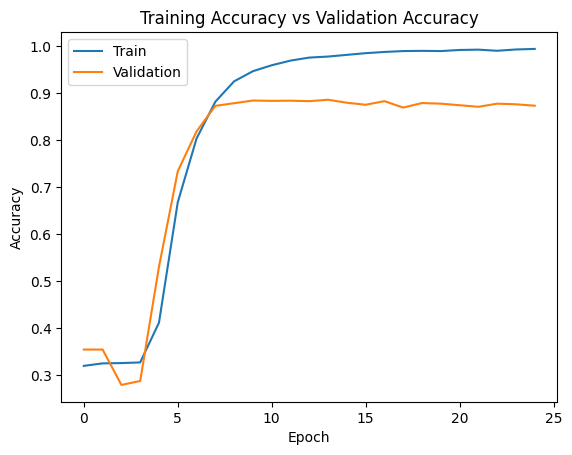

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

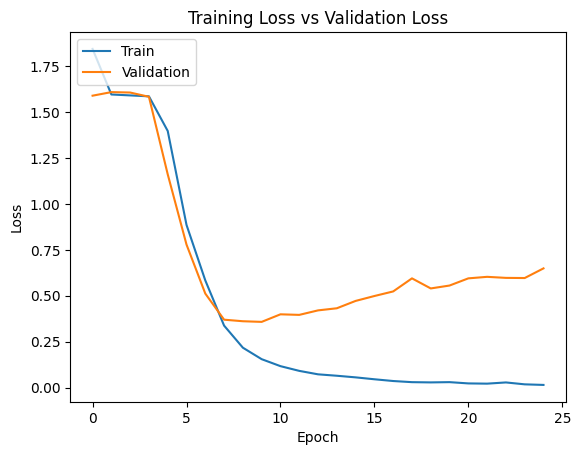

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 5. 2 | Test The Model

In [33]:
def get_text(text):
    tokenizer3 = Tokenizer()
    tokenizer3.fit_on_texts(text)
    word_index3 = tokenizer3.word_index
    
    stemmed_wordss = [stemmer.stem(word) for word in word_index3.keys()]
   
    tokens_list= tokenizer2.texts_to_sequences([stemmed_wordss])[0]

    for i in range(len(tokens_list)):
        for j in range(length_of_longest_sentence-len(tokens_list)):
            tokens_list.append(0)
    return tokens_list


In [34]:
 for _ in range(5):
    random_number = random.randint(0, 1000)
    num_to_predicte = random_number

    test = get_text([test_data['text'][num_to_predicte]])

    test = np.array(test)
    test = test.reshape(1, len(test))

    # Make predictions
    predictions = model.predict(test)

    predicted_class = np.argmax(predictions)
    print()
    print('Random value = ',random_number)
    print("Predicted Class:", predicted_class,labels_dict.get(predicted_class))
    print("Actual Class:", test_data['label'][num_to_predicte])
    print()

1/1 [==============================] - 1s 725ms/step

Random value =  172
Predicted Class: 1 joy
Actual Class: 1

1/1 [==============================] - 0s 20ms/step

Random value =  660
Predicted Class: 0 sadness
Actual Class: 3

1/1 [==============================] - 0s 20ms/step

Random value =  450
Predicted Class: 0 sadness
Actual Class: 0

1/1 [==============================] - 0s 20ms/step

Random value =  586
Predicted Class: 4 fear
Actual Class: 0

1/1 [==============================] - 0s 21ms/step

Random value =  252
Predicted Class: 0 sadness
Actual Class: 0



### 5. 2 | Confusion Matrix

In [35]:
new_test_data=preprocess_data(test_data)

test_X = [row[0] for row in new_train_data]
test_y = [row[1] for row in new_train_data]

for i in range(len(test_X)):
    for j in range(length_of_longest_sentence-len(test_X[i])):
        test_X[i].append(0)
        
test_X = np.array(test_X) 
test_y = np.array(test_y)  

test_y_one_hot = to_categorical(test_y, num_classes=16000)

In [36]:
y_pred = model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)

500/500 [==============================] - 2s 4ms/step


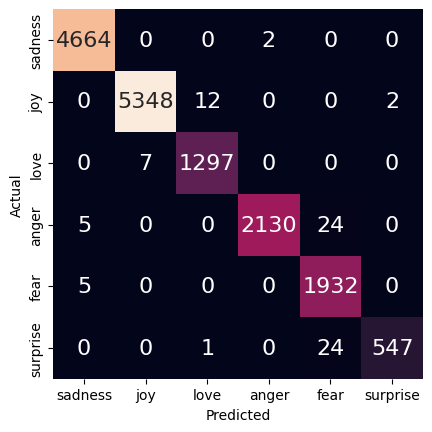

In [37]:
y_true_labels = np.argmax(test_y_one_hot, axis=1)

labels=['sadness','joy','love','anger','fear','surprise']
#labels = list(set(labels).intersection(set(np.unique(y_true_labels)).union(set(np.unique(y_pred_classes)))))

cm = confusion_matrix(y_true_labels, y_pred_classes)
df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={'size': 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 6) 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
ax.invert_yaxis() 
plt.show()
